In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [2]:
from langchain_groq import ChatGroq

llm=ChatGroq(model_name="deepseek-r1-distill-llama-70b",temperature=0)

In [3]:
response=llm.invoke("What is the length of great chaina wall?")
response

AIMessage(content="<think>\nOkay, so I need to figure out the length of the Great Wall of China. I've heard it's really long, but I'm not exactly sure how long. I remember seeing some numbers in the past, but I think they might vary. Let me try to break this down step by step.\n\nFirst, I know the Great Wall is an ancient series of fortifications built across several Chinese dynasties. It was constructed to protect the borders of China from invasions. So, it's not just one continuous wall but a collection of walls built over time. That probably means the total length isn't straightforward because it includes multiple sections built in different periods.\n\nI've heard people say it's about 13,000 miles long, but I also recall that this number might not be accurate. Maybe it's a common misconception. I think the actual length is less than that. I remember reading somewhere that a more precise measurement was done, possibly using satellite imagery or some advanced mapping techniques.\n\nW

In [4]:
from langchain.tools import tool

## This is custom tool building

In [5]:
@tool
def addition(a:int,b:int)-> int:
    """
    Add two integer numbers.
    Args:
        a (int): the first integer
        b (int): the second integer

    Returns:
        int: the addition of a and b.

    """
    return a+b

@tool
def multiply(a:int,b:int)-> int:
    """
    Multiplication of two integer numbers.
    Args:
        a (int): the first integer
        b (int): the second integer

    Returns:
        int: the product of a and b.

    """
    return a*b

@tool
def devide(a:int,b:int)->float:
    """
    Division of two integer numbers.
    Args:
        a (int): the first integer that is numerator
        b (int): the second integer that is denomenator must not be 0.

    Returns:
        float: integer a divided by the another integer number b.

    """
    if b==0:
        raise ValueError("Denomenator can not be zero.")
    return a/b




### Importing some inbuilt tools

In [6]:
from langchain_community.tools import DuckDuckGoSearchRun

web_search=DuckDuckGoSearchRun()

In [7]:
web_search.invoke("Who won the last match of IND vs ENG?")

"This was the 11th time that Stokes has opted to bowl first, and England have won eight of those games; they have lost only twice, a narrow defeat at Lord's in the 2023 Ashes and a 423-run ... The match is on a knife edge with India needing 10 wickets to win while England are 350 runs away. According to AccuWeather , rain could interrupt play multiple times during the day. England on brink of staggering victory over India Fri 20 Jun 2025 - Tue 24 Jun 2025 , Men's International Test Match Series - 1st Test - Day 5 of 5 England (batting) vs India, in play IND vs ENG LIVE Cricket Score, 1st Test Day 5: Potential epic coming up as final session begins; England 275/4, need 96 to win IND vs ENG 1st Test Day 5 LIVE Cricket Score, India vs England Test Match Today Live Score Updates: India looked down and out but Prasidh Krishna and Shardul Thakur struck out of nowhere to give the visitors a chance that looked improbable for much of the second session. India require 10 wickets to win the 1st T

In [8]:
multiply.invoke({'a':5,'b':2})

10

In [9]:
tools=[addition,multiply,devide,web_search]

In [10]:
llm_bind_tools=llm.bind_tools(tools)

In [11]:
response=llm_bind_tools.invoke("hi")

In [12]:
response.content

'Hello! How can I assist you today?'

In [13]:
response.tool_calls

[]

In [14]:
response=llm_bind_tools.invoke("What is 5+2?")

In [15]:
response.content

''

In [16]:
response.tool_calls

[{'name': 'addition',
  'args': {'a': 5, 'b': 2},
  'id': 'zzp943ebr',
  'type': 'tool_call'}]

In [17]:
response=llm_bind_tools.invoke("What is age of TATA group till now?")

In [18]:
response.content

''

In [19]:
response.tool_calls

[{'name': 'duckduckgo_search',
  'args': {'query': 'TATA group founding year'},
  'id': 'j29t6psef',
  'type': 'tool_call'}]

In [20]:
from langgraph.graph import StateGraph,START,END,MessagesState

In [ ]:
syatem_prompt="""You are a helpful assistant tasked with using search and arithmetic operation on a set of given input"""

In [44]:
def llm_call(state:MessagesState):
    question=state['messages']
    input_question=[syatem_prompt] + question
    response=llm_bind_tools.invoke(input_question)
    return {"messages":[response]}

In [46]:
workflow=StateGraph(MessagesState)

In [47]:
workflow.add_node('llm_decision_step',llm_call)

In [48]:
from langgraph.prebuilt import ToolNode
workflow.add_node(ToolNode(tools))

In [49]:
workflow.add_edge(START,'llm_decision_step')

In [50]:
from langgraph.prebuilt import tools_condition
workflow.add_conditional_edges('llm_decision_step',tools_condition)

In [51]:
workflow.add_edge('tools','llm_decision_step')

In [52]:
app=workflow.compile()

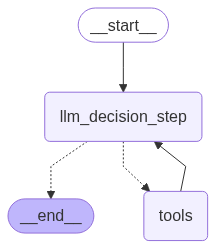

In [53]:
from IPython.display import display,Image
display(Image(app.get_graph().draw_mermaid_png()))

In [54]:
for output in app.stream({"messages":["What is the 5+8?"]}):

    for key,value in output.items():
        print("This is from node: ",key)
        print("--------")
        print(value)
        print("\n")

This is from node:  llm_decision_step
--------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'tbzcab6p4', 'function': {'arguments': '{"a":5,"b":8}', 'name': 'addition'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 270, 'prompt_tokens': 431, 'total_tokens': 701, 'completion_time': 1.120161939, 'prompt_time': 0.034648771, 'queue_time': 0.054003538, 'total_time': 1.15481071}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cfa0e72e-6a2e-44d4-ad54-db15772ddcfd-0', tool_calls=[{'name': 'addition', 'args': {'a': 5, 'b': 8}, 'id': 'tbzcab6p4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 431, 'output_tokens': 270, 'total_tokens': 701})]}


This is from node:  tools
--------
{'messages': [ToolMessage(content='13', name='addition', id='dee1da64-ca9d-4fbb-a813-f6f06456b608', tool_call_id='tbzcab6p4')]}


This is from node:  l

In [55]:
for output in app.stream({"messages":["Who won the last test match IND vs ENG?"]}):

    for key,value in output.items():
        print("This is from node: ",key)
        print("--------")
        print(value)
        print("\n")

This is from node:  llm_decision_step
--------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'cmxz3jf6a', 'function': {'arguments': '{"query":"IND vs ENG last test match result"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 133, 'prompt_tokens': 433, 'total_tokens': 566, 'completion_time': 0.516688656, 'prompt_time': 0.02771572, 'queue_time': 0.058167720000000006, 'total_time': 0.544404376}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--581acf71-dcc5-42d3-9b1a-aad18eb66dcc-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'IND vs ENG last test match result'}, 'id': 'cmxz3jf6a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 433, 'output_tokens': 133, 'total_tokens': 566})]}


This is from node:  tools
--------
{'messages': [ToolMessage(content="Follow our live cricket upd

In [56]:
from langchain_core.messages import HumanMessage

In [58]:
messages=[HumanMessage(content="What is the net worth of Elon Musk and what will be the 50% of his wealth?")]

In [59]:
for output in app.stream({"messages":messages}):

    for key,value in output.items():
        print("This is from node: ",key)
        print("--------")
        print(value)
        print("\n")

This is from node:  llm_decision_step
--------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'f1yamvsz4', 'function': {'arguments': '{"query":"Elon Musk net worth 2023"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 334, 'prompt_tokens': 443, 'total_tokens': 777, 'completion_time': 1.397803929, 'prompt_time': 0.036047626, 'queue_time': 0.052407763999999996, 'total_time': 1.433851555}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--6b2b9c7f-9f6a-4ba7-be8d-ccb63749c737-0', tool_calls=[{'name': 'duckduckgo_search', 'args': {'query': 'Elon Musk net worth 2023'}, 'id': 'f1yamvsz4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 443, 'output_tokens': 334, 'total_tokens': 777})]}


This is from node:  tools
--------
{'messages': [ToolMessage(content="Musk owns an estimated 54% of xAI, which he 

In [60]:
messages=[HumanMessage(content="What is the speed of light in m/s and multiply the speed by 10?")]

In [62]:
for output in app.stream({"messages":messages}):

    for key,value in output.items():
        print("This is from node: ",key)
        print("--------")
        print(value)
        print("\n")

This is from node:  llm_decision_step
--------
{'messages': [AIMessage(content='The speed of light in meters per second is approximately **299,792,458 m/s**. When multiplied by 10, the result is **2,997,924,580 m/s**.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 197, 'prompt_tokens': 440, 'total_tokens': 637, 'completion_time': 0.716363636, 'prompt_time': 0.03689541, 'queue_time': 0.0573716, 'total_time': 0.753259046}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'stop', 'logprobs': None}, id='run--61fcba25-a505-4e87-af21-72c5726a1d94-0', usage_metadata={'input_tokens': 440, 'output_tokens': 197, 'total_tokens': 637})]}




In [63]:
import yfinance as yf

In [64]:
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing stock price of a given stock ticker from the Yahoo Finance.
    Args:
        ticker(str): The stock ticker symbol (e.g. 'AAPL', 'TSLA', 'NIFTY.BO' etc)

    Returns:
        str: A message with the stock's previous closing price. 
    """
    try:
        stock=yf.Ticker(ticker)
        price=stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch the price for ticker: {ticker}"
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occured while fetching stock data: {str(e)}."

In [65]:
get_stock_price('AAPL')

C:\Users\Hp\AppData\Local\Temp\ipykernel_320\3955064537.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  get_stock_price('AAPL')


'The last closing price of AAPL was $201.50.'

In [66]:
get_stock_price.invoke('TSLA')

'The last closing price of TSLA was $348.68.'

In [67]:
tools=[addition,multiply,devide,web_search,get_stock_price]

In [68]:
llm_bind_tools=llm.bind_tools(tools)

In [69]:
response=llm_bind_tools.invoke("What is the stock price of Adani green energy?")

In [70]:
response.content

''

In [71]:
response.tool_calls

[{'name': 'get_stock_price',
  'args': {'ticker': 'ADANIGREEN.NS'},
  'id': '788vbkyq4',
  'type': 'tool_call'}]

In [82]:
syatem_prompt="""You are a helpful assistant tasked with search in duckduckgo,stock price from yahoo finance,arithmetic operations of given numbers ."""
def llm_call(state:MessagesState):
    question=state['messages']
    input_question=[syatem_prompt] + question
    response=llm_bind_tools.invoke(input_question)
    return {"messages":[response]}

In [83]:
workflow=StateGraph(MessagesState)
workflow.add_node('llm_decision_step',llm_call)
workflow.add_node(ToolNode(tools))
workflow.add_edge(START,'llm_decision_step')
workflow.add_conditional_edges('llm_decision_step',tools_condition)
workflow.add_edge('tools','llm_decision_step')
app=workflow.compile()

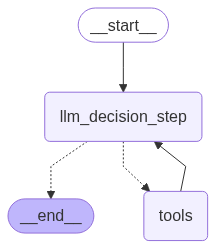

In [84]:
display(Image(app.get_graph().draw_mermaid_png()))

In [85]:
messages=[HumanMessage(content="add 1000 with the current stock price of AAPL.")]
for output in app.stream({"messages":messages}):

    for key,value in output.items():
        print("This is from node: ",key)
        print("--------")
        print(value)
        print("\n")

This is from node:  llm_decision_step
--------
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'y3fe5xajn', 'function': {'arguments': '{"ticker":"AAPL"}', 'name': 'get_stock_price'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 140, 'prompt_tokens': 541, 'total_tokens': 681, 'completion_time': 0.58043664, 'prompt_time': 0.042898986, 'queue_time': 0.302020049, 'total_time': 0.623335626}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_1bbe7845ec', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--84d4b0fe-86a1-4e14-aa70-711f30e753cd-0', tool_calls=[{'name': 'get_stock_price', 'args': {'ticker': 'AAPL'}, 'id': 'y3fe5xajn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 541, 'output_tokens': 140, 'total_tokens': 681})]}


This is from node:  tools
--------
{'messages': [ToolMessage(content='The last closing price of AAPL was $201.50.', name='get_stock_price', id='472c205f-c927-4aff-adc

In [90]:
messages=[HumanMessage(content="the current stock price of Apple and latest news about apple.")]
response=app.invoke({"messages":messages})

In [91]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

the current stock price of Apple and latest news about apple.
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (spfeatn00)
 Call ID: spfeatn00
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

The last closing price of AAPL was $201.50.
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (s1kpzax8f)
 Call ID: s1kpzax8f
  Args:
    query: latest news about Apple
================================= Tool Message =================================
Name: duckduckgo_search

At today's WWDC 2025 keynote event, Apple unveiled a new design that will inform the next decade of iOS, iPadOS, and macOS development, so needless to say, it was a busy day. Apple also unveiled a ... Find news about Apple Company News in the App